In [1]:
import numpy as np
import matplotlib.pyplot as plt
from battery_model import BatteryModel
from data import DataProvider
from GA import GeneticAlgorithm
from sklearn.metrics import r2_score
from scipy.optimize import least_squares


In [2]:
battery_model = BatteryModel()

In [3]:
data_provider = DataProvider()
df = data_provider.read_excel()

In [4]:
df = data_provider.scale_data(df)
df.head()

,Timestamp,Battery Voltage(V),Battery Current(A),SoC(%),time_diff_sec,SoC
1,2025-02-10 22:12:37,52.5750,0.29,74,5.0,0.74
2,2025-02-10 22:18:14,52.5750,0.29,74,5.0,0.74
3,2025-02-10 22:23:51,52.6000,-0.04,74,5.0,0.74
4,2025-02-10 22:29:28,52.6000,0.00,74,5.0,0.74
5,2025-02-10 22:35:05,52.6125,-0.03,74,5.0,0.74


In [5]:
# optimal_params = battery_model.get_optimal_ABCD_params()
# A_opt, B_opt, C_opt, D_opt = optimal_params.x
C_opt = 1.2

print(f"Optimized C Value: {C_opt:.4f}")

# plt.figure(figsize=(8, 5))
# plt.scatter(battery_model.cycles, battery_model.capacity, label="Measured Data", color="red")
# plt.plot(battery_model.cycles, battery_model.degradation_model(optimal_params.x, battery_model.cycles), label="Fitted Model", linestyle="--")
# plt.xlabel("Cycle Count")
# plt.ylabel("Remaining Capacity (%)")
# plt.legend()
# plt.title("Battery Degradation Model Fit")
# plt.grid()
# plt.show()

Optimized C Value: 1.2000


In [6]:
def objective_function(params, df, C, isCharging):
    predicted_vals = []
    true_vals = []

    for _, row in df.iterrows():
        soc = row["SoC"]
        I = row["Battery Current(A)"]
        t = row["time_diff_sec"]

        predicted_v = battery_model.terminal_voltage(I, t, C, params, soc, isCharging) #p["R1"], max(p["R2"], 1e-3), max(p["C1"], 1e-3), p["V0"]
        predicted_vals.append(predicted_v)
        true_vals.append(row["Battery Voltage(V)"])

    predicted_vals = np.array(predicted_vals)
    true_vals = np.array(true_vals)

    mse = np.mean((true_vals - predicted_vals) ** 2)

    #penalize error spread instead of raw prediction variance
    errors = true_vals - predicted_vals
    spread_penalty = np.var(errors)
    alpha = 0.5

    return mse + alpha * spread_penalty

In [7]:
def plot(measured_df, predicted_df, isCharging):
    plt.figure(figsize=(8, 5))

    plt.plot(
        measured_df["SoC"], 
        measured_df["Battery Voltage(V)"], 
        marker='o', 
        linestyle='-', 
        label="Mean Voltage", 
        color='blue'
    )

    plt.plot(
        measured_df["SoC"], 
        predicted_df, 
        color='black',
        marker='o', 
        linestyle='-',
        label="Predicted Voltage", 
        alpha=0.5
    )

    plt.xlabel("State of Charge (SoC)")
    plt.ylabel("Voltage (V)")
    plt.title("Voltage vs. SoC")
    plt.legend()
    plt.grid(True)

    if isCharging == False:
        # Reverse the x-axis to display from 1 to 0
        plt.gca().invert_xaxis()

    plt.tight_layout()
    plt.show()

In [9]:
charging_df = data_provider.get_charging_data(df)
charging_df.head(100)


,SoC,Battery Voltage(V),Battery Current(A),time_diff_sec
0,0.19,51.665000,-2.682000,5.000000
1,0.20,52.268750,-4.970000,3.000000
2,0.21,51.918750,-2.665000,4.333333
3,0.22,52.125000,-3.910000,5.000000
4,0.23,51.709375,-0.940000,5.000000
...,...,...,...,...
77,0.96,54.205392,-12.790000,4.862745
78,0.97,54.164750,-11.734800,4.940000
79,0.98,54.325980,-11.724314,4.784314
80,0.99,53.947576,-4.510327,4.871460


In [10]:
discharging_df = data_provider.get_discharging_data(df)
discharging_df.head(100)

,SoC,Battery Voltage(V),Battery Current(A),time_diff_sec
0,0.19,51.330660,0.426604,4.905660
1,0.20,51.462500,0.337407,4.876543
2,0.21,51.543023,0.587442,4.976744
3,0.22,51.568015,0.507353,4.852941
4,0.23,51.685357,0.736857,4.857143
...,...,...,...,...
77,0.96,52.866154,8.711077,4.907692
78,0.97,52.957639,6.265833,4.847222
79,0.98,52.929386,6.536491,4.894737
80,0.99,53.083015,6.513740,4.824427


In [11]:
actual_voltages_charging = charging_df["Battery Voltage(V)"]
actual_voltages_discharging = discharging_df["Battery Voltage(V)"]

In [ ]:
# Running LSM for charging
initial_guess = np.array([
        7.85231184e-02, 4.40647431e-02, 5.29996992e-02, 5.39618467e+00,
        9.27903476e-03, 9.26349258e-03, 9.22953733e-03, 1.06815413e-01,
        9.96646781e-02, 7.80931383e-02, 6.54827944e+00, 9.20989068e-03,
        9.24046561e-03, 9.20959401e-03, 1.66975752e+00, 9.45711252e-01,
        1.05770358e+00, 6.05011245e-01, 8.02279668e-01, 5.59429726e-01,
        7.18991714e-01, 1.04206319e+01, 1.02679365e+01, 1.01882110e+01,
        9.23302598e-02, 1.03816029e+01, 4.32625090e+00, 6.06022845e-01,
        1.66211626e-01, 1.36376529e-03, 1.01615923e+01
        ])  #np.random.uniform(0.001, 1.0, 31)
result_lsm = least_squares(objective_function, initial_guess, args=(charging_df, C_opt, True), bounds=(0, np.inf))
best_params_lsm_charging = result_lsm.x

print("Optimized Parameters (LSM):", best_params_lsm_charging)

Optimized Parameters (LSM): [6.44936724e-01 6.03032267e-01 5.74053119e-01 9.04837071e+00
 9.33272217e-03 9.33272217e-03 9.33272217e-03 2.95962299e-01
 2.31490084e-01 3.24704320e-01 6.96997509e+00 1.56294335e-02
 1.57451642e-02 1.56674319e-02 2.61250812e+00 2.60988892e+00
 3.33711793e+00 2.70121122e+00 1.71991818e+00 4.79483222e+00
 1.94443310e+00 1.02821405e+01 9.81625805e+00 1.03942044e+01
 2.59416079e-02 9.88043038e+00 2.98693310e+00 8.47511294e-01
 5.96418483e-01 1.65123130e-04 9.86508659e+00]


In [13]:
predicted_voltages_lsm_charging = battery_model.get_predicted_voltages(charging_df, C_opt, best_params_lsm_charging, isCharging=True)

In [14]:
r2 = r2_score(actual_voltages_charging, predicted_voltages_lsm_charging)
print(f"Coefficient of Determination (R²): {r2:.4f}")

Coefficient of Determination (R²): 0.7162


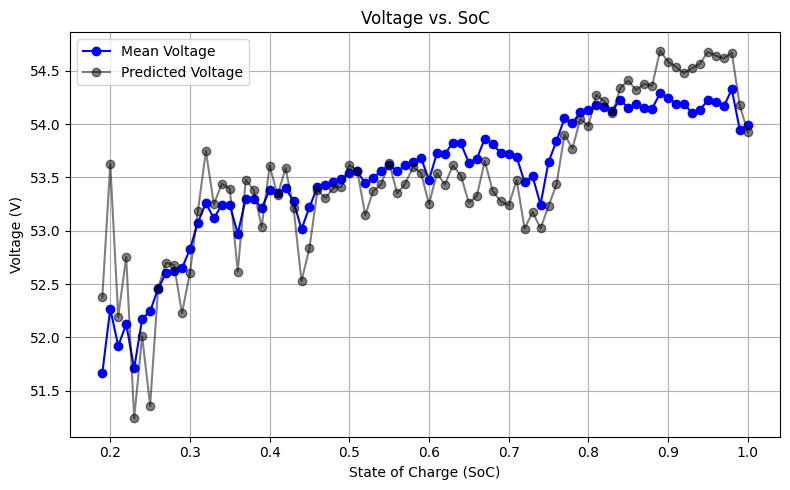

In [15]:
plot(charging_df, predicted_voltages_lsm_charging, isCharging=True)

In [ ]:
# Running LSM for discharging
result_lsm = least_squares(objective_function, initial_guess, args=(discharging_df, C_opt, False), bounds=(0, np.inf))
best_params_lsm_discharging = result_lsm.x

print("Optimized Parameters (LSM):", best_params_lsm_discharging)

Optimized Parameters (LSM): [1.34717983e-03 1.45169516e-03 7.23249854e-04 4.69444609e+00
 2.15093254e-29 1.64729559e-29 1.84615333e-29 2.05453019e-01
 2.07396951e-01 2.21818358e-01 1.31378543e+00 2.27403693e-01
 2.30352404e-01 2.23338617e-01 1.59173461e+00 1.37445984e+00
 1.48790097e+00 3.75513773e+00 4.98740820e+00 3.54835432e+00
 4.88756140e+00 7.62154026e-01 3.10469270e-01 6.96991177e-01
 1.27151596e+00 4.01813859e-01 6.32573084e-01 3.87519050e-01
 2.40496399e-01 1.74343931e+00 6.32787301e-01]


In [17]:
predicted_voltages_lsm_discharging = battery_model.get_predicted_voltages(discharging_df, C_opt, best_params_lsm_discharging, isCharging=False)

In [18]:
r2 = r2_score(actual_voltages_discharging, predicted_voltages_lsm_discharging)
print(f"Coefficient of Determination (R²): {r2:.4f}")

Coefficient of Determination (R²): -3.3332


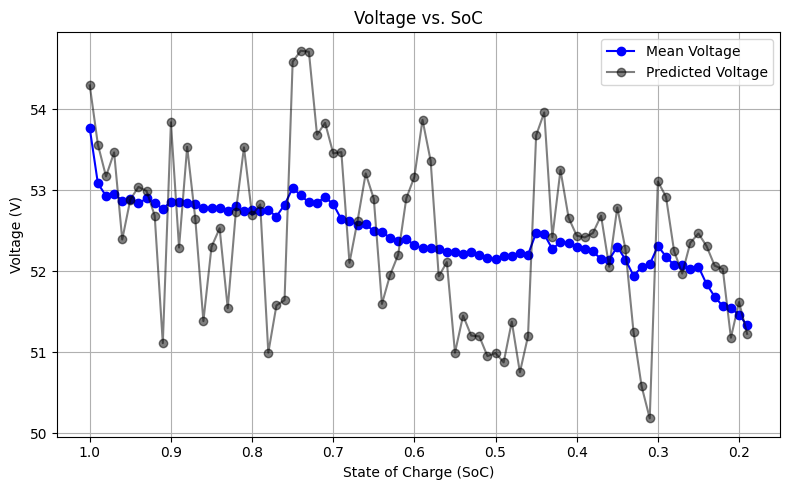

In [19]:
plot(discharging_df.sort_values(by="SoC", ascending=False), predicted_voltages_lsm_discharging[::-1], isCharging=False)

Generation: 1; Best fitness: 0.3345
Generation: 2; Best fitness: 0.2273
Generation: 3; Best fitness: 0.1889
Generation: 4; Best fitness: 0.1533
Generation: 5; Best fitness: 0.2401
Generation: 6; Best fitness: 0.2119
Generation: 7; Best fitness: 0.1886
Generation: 8; Best fitness: 0.1886
Generation: 9; Best fitness: 0.2195
Generation: 10; Best fitness: 0.1562
Generation: 11; Best fitness: 0.1562
Generation: 12; Best fitness: 0.1672
Generation: 13; Best fitness: 0.2100
Generation: 14; Best fitness: 0.1859
Generation: 15; Best fitness: 0.1723
Generation: 16; Best fitness: 0.1630
Generation: 17; Best fitness: 0.1474
Generation: 18; Best fitness: 0.1287
Generation: 19; Best fitness: 0.1459
Generation: 20; Best fitness: 0.1401
Generation: 21; Best fitness: 0.1531
Generation: 22; Best fitness: 0.1432
Generation: 23; Best fitness: 0.1209
Generation: 24; Best fitness: 0.1209
Generation: 25; Best fitness: 0.1205
Generation: 26; Best fitness: 0.1263
Generation: 27; Best fitness: 0.1310
Generation

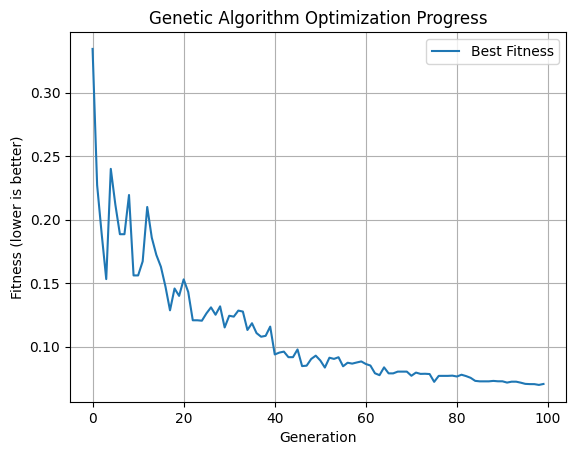

Optimized Parameters (GA): [2.44830129e-01 1.93087944e-01 9.15407700e-01 8.90601157e+00
 1.14430146e-02 2.01268877e-02 2.23458127e-02 8.53879136e-03
 2.12035448e-01 2.33593678e-01 6.76220163e+00 0.00000000e+00
 0.00000000e+00 8.93750739e-03 2.23325784e+00 2.97811335e+00
 2.96525935e+00 3.03021727e+00 1.44893992e+00 5.36628138e+00
 1.92178773e+00 1.03229189e+01 9.90362741e+00 1.00227444e+01
 0.00000000e+00 1.05518165e+01 2.80920639e+00 4.20345180e-01
 4.66594072e-03 1.90951028e-01 9.95174390e+00]


In [20]:
# Running GA for charging
ga_optimizer = GeneticAlgorithm()
ga_optimizer.init_generation(best_params_lsm_charging)
best_params_ga = ga_optimizer.optimize(charging_df, C_opt, objective_function, isCharging=True)
print("Optimized Parameters (GA):", best_params_ga)

In [21]:
predicted_voltages_ga_charging = battery_model.get_predicted_voltages(charging_df, C_opt, best_params_ga, isCharging=True)

In [22]:
r2 = r2_score(actual_voltages_charging, predicted_voltages_ga_charging)
print(f"Coefficient of Determination (R²): {r2:.4f}")

Coefficient of Determination (R²): 0.8820


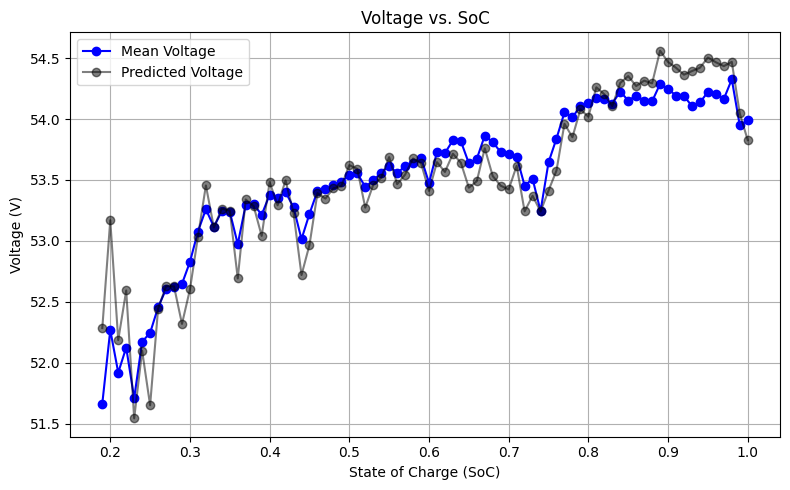

In [23]:
plot(charging_df, predicted_voltages_ga_charging, isCharging=True)

Generation: 1; Best fitness: 3.6651
Generation: 2; Best fitness: 3.2718
Generation: 3; Best fitness: 1.6931
Generation: 4; Best fitness: 1.6015
Generation: 5; Best fitness: 1.5419
Generation: 6; Best fitness: 1.5910
Generation: 7; Best fitness: 1.8459
Generation: 8; Best fitness: 1.5453
Generation: 9; Best fitness: 1.6962
Generation: 10; Best fitness: 1.6934
Generation: 11; Best fitness: 1.5402
Generation: 12; Best fitness: 1.5136
Generation: 13; Best fitness: 1.7440
Generation: 14; Best fitness: 1.6508
Generation: 15; Best fitness: 1.7053
Generation: 16; Best fitness: 1.5746
Generation: 17; Best fitness: 1.8010
Generation: 18; Best fitness: 1.5914
Generation: 19; Best fitness: 1.5360
Generation: 20; Best fitness: 1.5263
Generation: 21; Best fitness: 1.5263
Generation: 22; Best fitness: 1.5343
Generation: 23; Best fitness: 1.5274
Generation: 24; Best fitness: 1.6678
Generation: 25; Best fitness: 1.5916
Generation: 26; Best fitness: 1.6313
Generation: 27; Best fitness: 1.6313
Generation

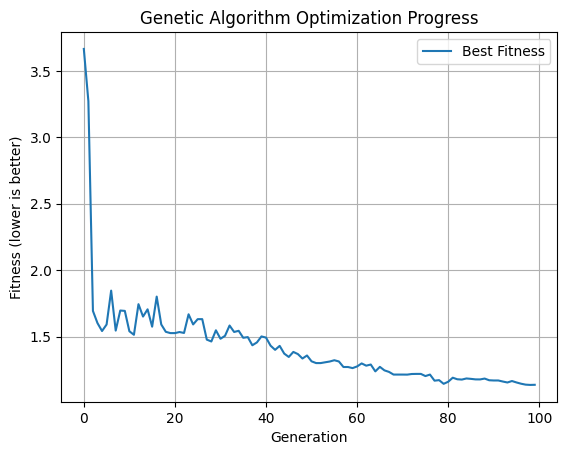

Optimized Parameters (GA): [0.2469348  0.00632676 0.05356947 5.1537377  0.         0.
 0.         0.04139997 0.16339396 0.50560185 0.96372593 0.08883341
 0.01170727 0.45583679 1.13094875 2.01246024 1.80592869 4.51244784
 4.77182566 3.63824397 5.30224495 0.76008361 0.48181968 0.61232673
 1.36831679 0.18646825 0.47437581 0.60345589 0.62505982 1.39295558
 0.10794267]


In [ ]:
# Running GA for discharging
ga_optimizer = GeneticAlgorithm()
ga_optimizer.init_generation(best_params_lsm_discharging)
best_params_ga_discharging = ga_optimizer.optimize(discharging_df, C_opt, objective_function, isCharging=False)
print("Optimized Parameters (GA):", best_params_ga_discharging)

In [25]:
predicted_voltages_ga_discharging = battery_model.get_predicted_voltages(discharging_df, C_opt, best_params_ga_discharging, isCharging=False)

In [26]:
r2 = r2_score(actual_voltages_discharging, predicted_voltages_ga_discharging)
print(f"Coefficient of Determination (R²): {r2:.4f}")

Coefficient of Determination (R²): -3.4602


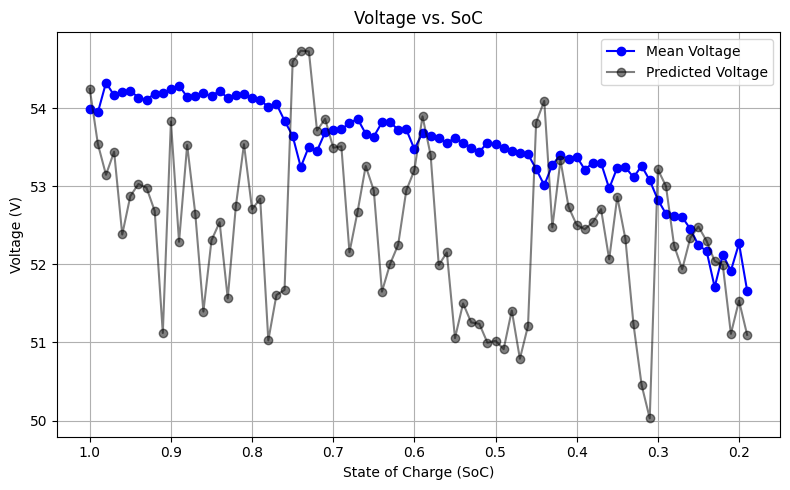

In [27]:
plot(charging_df.sort_values(by="SoC", ascending=False), predicted_voltages_ga_discharging[::-1], isCharging=False)